In [1]:
import wfdb
import numpy as np
import os
import pandas as pd
import math
import h5py
import matplotlib.pyplot as plt
import re

In [2]:
def print_object_attributes(obj): #https://stackoverflow.com/questions/192109/is-there-a-built-in-function-to-print-all-the-current-properties-and-values-of-a
    for attr in dir(obj):
        print("obj.%s = %r" % (attr, getattr(obj, attr)))

### Read MIT format .dat ecg data files and .hea headers

In [3]:
#Download first at: https://physionet.org/content/ptbdb/1.0.0/
#BASE_DIR = '/media/julian/Volume/data/ECG/mit-bih-arrhythmia-database-1.0.0/' #Arrhythmia
BASE_DIR = '/media/julian/Volume/data/ECG/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
def get_file_list(BASE_DIR, relative=True, filter_function=None):
    record_files = []
    #file_endings = ['.dat', '.hea', '.xyz']
    with open(os.path.join(BASE_DIR, 'RECORDS')) as recs:
        record_files = recs.read().splitlines()
    if filter_function:
        record_files = list(filter(filter_function, record_files))
    if not relative:
        record_files = [os.path.join(BASE_DIR, f) for f in record_files]
    return record_files


record_files = get_file_list(BASE_DIR)
print(len(record_files), 'files found')

43674 files found


### Extract signal from *.dat files & Read annotations & Read comments

In [4]:
def read_comment_map_PTB(record_path):
    #print(record_path)
    record = wfdb.rdrecord(record_path)
    comment_map = {}
    for c in record.comments:
        e = c.split(':')
        comment_map[e[0]] = e[1].strip()
    return comment_map

In [5]:
def filter_comment(comment, key):
    c = comment
    if key == 'Reason for admission':
        if 'Cardiomyopathy' in c or 'Heart failure' in c:
            return 'Cardiomyopathy'
        elif 'n/a' in k or 'Palpitation' in k:
            return 'Miscellaneous'
        elif 'angina' in k:
            new_comments['Angina'] = comments[k]
        else:
            new_comments[k] = comments[k]

In [6]:
def read_comment(record_path):
    record = wfdb.rdrecord(record_path)
    return record.comments

In [7]:
def read_header(record_path):
    record = wfdb.rdheader(record_path, rd_segments=True)
    return record.comments

In [8]:
def read_signal(record_path, physical=True):
    #print(record_path)
    record = wfdb.rdrecord(record_path, physical=physical)
    #print_object_attributes(record)
    if physical:
        data = record.p_signal
    else:
        data = record.d_signal
    return data

In [9]:
def read_annotation(record_path, physical=True):
    try:
        annotation = wfdb.rdann(record_path, 'hea', return_label_elements=['symbol', 'label_store', 'description'])
        #print(record_path)
        #print('sample:', annotation.sample, 'symbol', annotation.symbol, 'contained labels', annotation.description)
        return (annotation.sample, annotation.symbol, annotation.label_store, annotation.description)
    except ValueError as ve:
        print(record_path, ' annotation read failed:', ve)
        return None

#### Save all signals and attributes in file_data (also note how many had functioning annotations)

In [10]:
def read_ptbxl_database():
    csvfile = os.path.join(BASE_DIR, 'ptbxl_database.csv')
    dataframe = pd.read_csv(csvfile)
    return dataframe

def read_ptbxl_scp_statements():
    csvfile = os.path.join(BASE_DIR, 'scp_statements.csv')
    dataframe = pd.read_csv(csvfile)
    return dataframe

def train_test_split(record_files_relative):
    df = read_ptbxl_csv()
    train, val, test = [], [], []
    for rf in record_files_relative:
        temp = rf.replace('resampled', '') #resampled file contains 'resampled' but csv not
        row = df.loc[(df['filename_hr'].str.contains(temp)) | (df['filename_lr'].str.contains(temp))]
        if len(row) < 1:
            print('no row found containing file', rf)
        fold = row['strat_fold'].values[0]
        if fold <= 8: #https://physionet.org/content/ptb-xl/1.0.1/ #Cross-validation Folds
            train.append(rf)
        elif fold == 9:
            val.append(rf)
        elif fold == 10:
            test.append(rf)
        else:
            print('found unknown strat fold number', fold)
        print("final split: train %d; validation %d; test %d" % (len(train), len(val), len(test)))
    return train, val, test

def read_label(ptbxl_database_dataframe, spc_codes_dataframe, rf, likelihood_threshold=0.0):
    df = ptbxl_database_dataframe
    spc_df = spc_codes_dataframe
    temp = rf.replace('resampled', '') #resampled file contains 'resampled' but csv not
    row = df.loc[(df['filename_hr'].str.contains(temp)) | (df['filename_lr'].str.contains(temp))]
    if len(row) < 1: 
        print(filename, 'not found in dataframe')
        return
    code = row['scp_codes'].values[0]
    labels = [(re.sub(r'\W+', '', c.split(':')[0]), c.split(':')[1].replace('}', '').strip()) for c in code.split(',')]
    diagnostic_classes = []
    for l, p in labels:
        if float(p) > likelihood_threshold:
            scp_row = spc_df.loc[(scp_df.iloc[:, 0] == l) | (spc_df['diagnostic_subclass'] == l)]
            if len(scp_row) < 1:
                print(l, 'not found in scp_statements')
                break
            diagnostic_classes.append((scp_row['diagnostic_class'].values[0], p))
    return sorted(diagnostic_classes, key=lambda x: x[1], reverse=True)

record_files500 = get_file_list(BASE_DIR, filter_function=lambda x: 'records500' in x)

db_df = read_ptbxl_database()
scp_df = read_ptbxl_scp_statements()
print(scp_df.iloc[:, 0])
read_label(db_df, scp_df, 'records500/00000/00001_hr')

0       NDT
1      NST_
2       DIG
3     LNGQT
4      NORM
      ...  
66     BIGU
67     AFLT
68    SVTAC
69     PSVT
70    TRIGU
Name: Unnamed: 0, Length: 71, dtype: object


[('NORM', '100.0')]

In [75]:
import ast
from collections import defaultdict
dbdf = read_ptbxl_database()
all_labels = defaultdict(set)

#Collect all possible labels
codes = dbdf['scp_codes']
for row in codes:
    lbl_dict = ast.literal_eval(row)
    for k,v in lbl_dict.items():
        all_labels[k].update({v})
        
#Filter out labels that have only 0 probablity
all_labels = {k: v for k, v in all_labels.items() if max(v) > 0.0}

#Build a dict with filename as key and scp code as values
filenames = dbdf[['filename_hr', 'scp_codes']]
file_codes = defaultdict(dict)
for i, (f, c) in filenames.iterrows():
    lbl_dict = ast.literal_eval(c)
    for k, v in lbl_dict.items():
        if k in all_labels and v > 0.0: #First check not necessary
            file_codes[f][k] = v/100.0

code_indices = dict(zip(all_labels.keys(), range(len(all_labels.keys()))))
file_codes_onehot = dict()
for k, v in file_codes.items():
    hot_prob = np.zeros(len(code_indices))
    for ck, cv in v.items():
        hot_prob[code_indices[ck]] = cv
    file_codes_onehot[k] = hot_prob
print(len(filenames), len(file_codes_onehot))


21837 21837


In [85]:
[a[0] for a in sorted(code_indices.items(), key=lambda x: x[1])]

['NORM',
 'IMI',
 'AFLT',
 'AFIB',
 'NDT',
 'NST_',
 'DIG',
 'LVH',
 'LPFB',
 'LNGQT',
 'LAFB',
 'IRBBB',
 'RAO/RAE',
 'RVH',
 'IVCD',
 'LMI',
 'ASMI',
 'AMI',
 'ISCAL',
 '1AVB',
 'STACH',
 'ISC_',
 'PACE',
 'ISCLA',
 'SEHYP',
 'ISCIL',
 'ILMI',
 'PVC',
 'CRBBB',
 'CLBBB',
 'ALMI',
 'ANEUR',
 'ISCAS',
 'PAC',
 'EL',
 'LAO/LAE',
 'ILBBB',
 'ISCIN',
 'INJAS',
 'INJAL',
 'IPMI',
 'WPW',
 'ISCAN',
 'INJLA',
 'BIGU',
 'IPLMI',
 '3AVB',
 'INJIL',
 '2AVB',
 'PSVT',
 'PMI',
 'INJIN']

In [11]:
import glob
p = '/media/julian/Volume/data/ECG/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/generated/1000'
for f in glob.glob(os.path.join(p, '*_hr.*')):
    fn = os.path.basename(f)
    fp = os.path.dirname(f)
    os.rename(f, os.path.join(fp, os.path.splitext(fn)[0]+'resampled'+os.path.splitext(fn)[1]))

## Playing around with PTB Comments

In [20]:
comment_data = []
success = 0
record_files = get_file_list(BASE_DIR, filter_function=lambda x: 'records500' in x)
for f in record_files:
    p = os.path.join(BASE_DIR, f)
    d = read_comment_map_PTB(p)
    comment_data.append(d)
print(comment_data[0])

{}


In [ ]:
comment_data

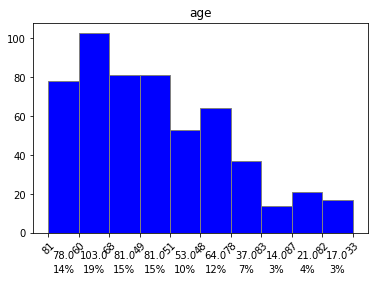

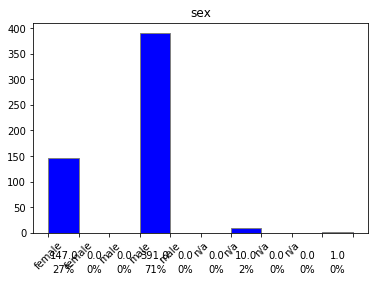

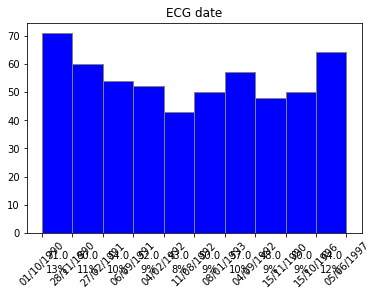

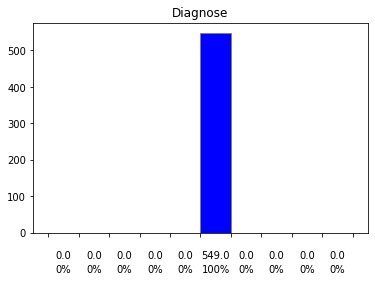

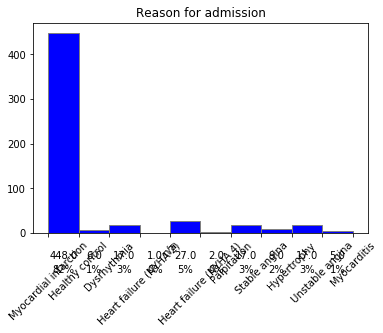

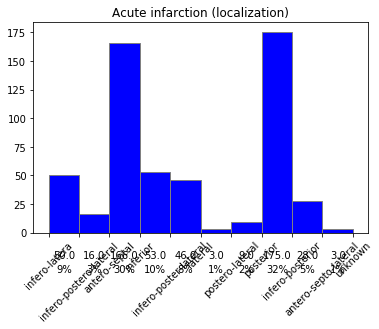

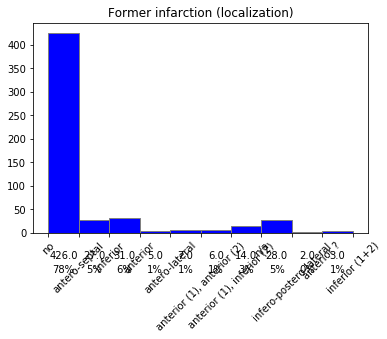

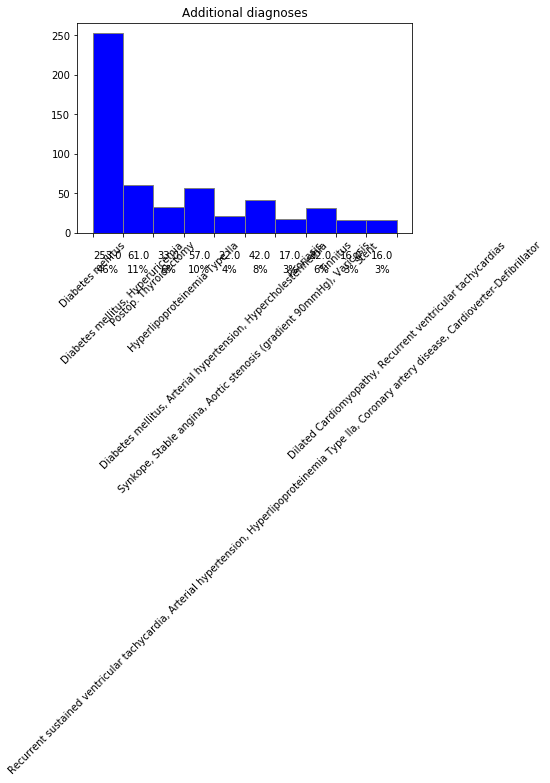

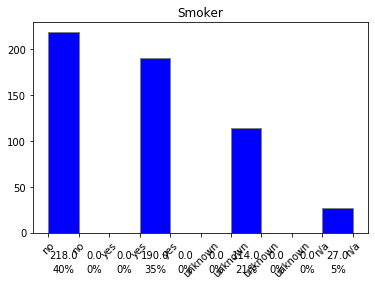

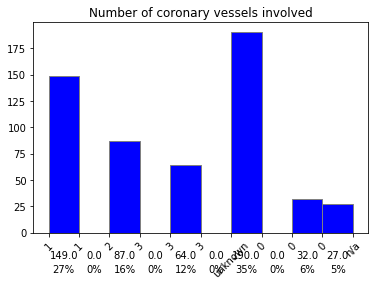

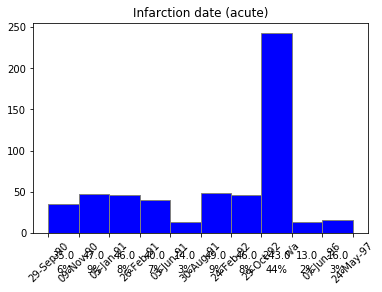

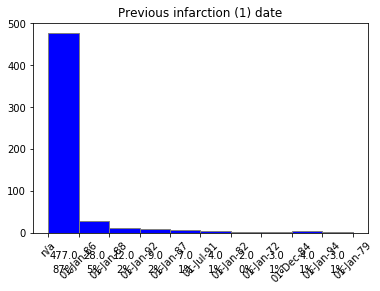

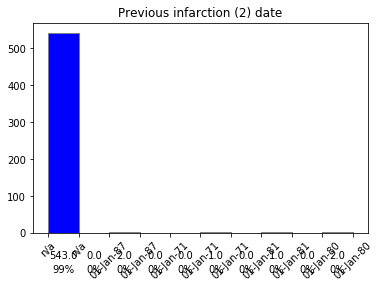

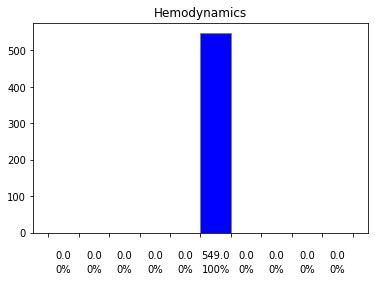

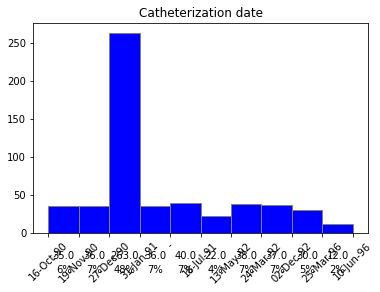

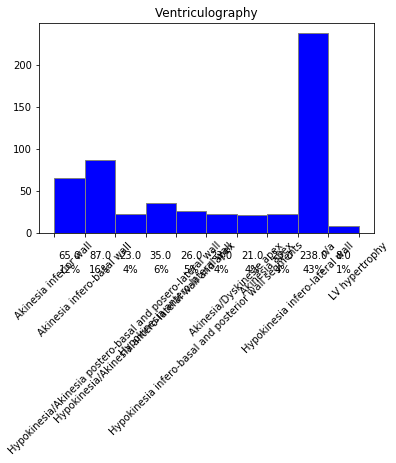

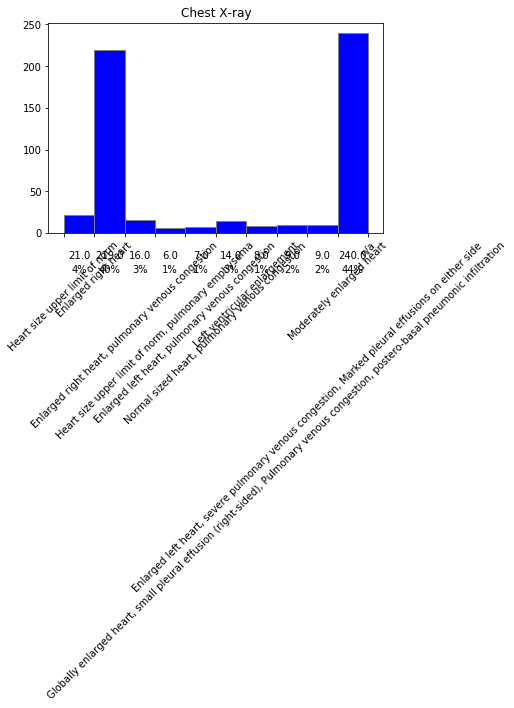

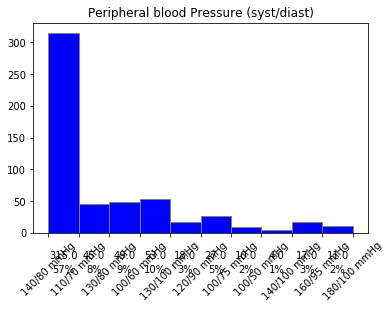

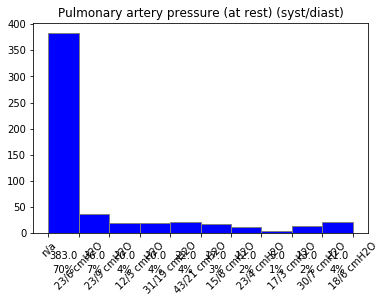

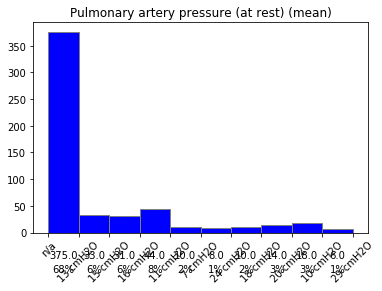

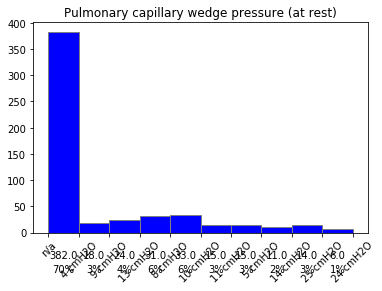

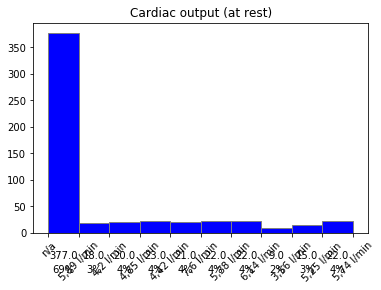

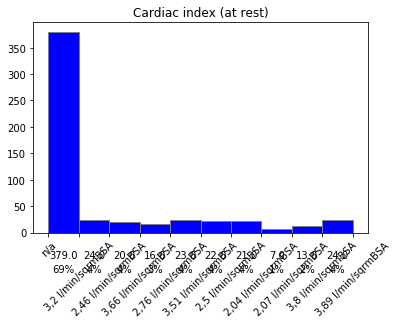

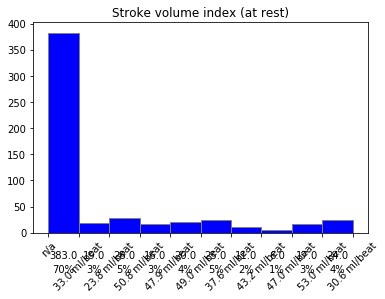

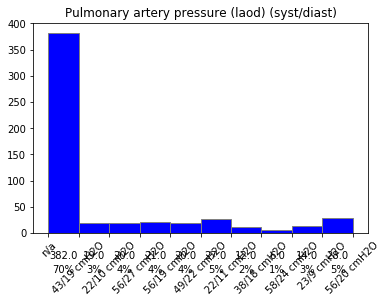

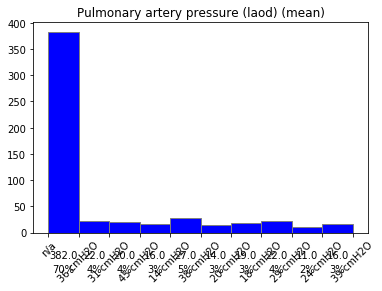

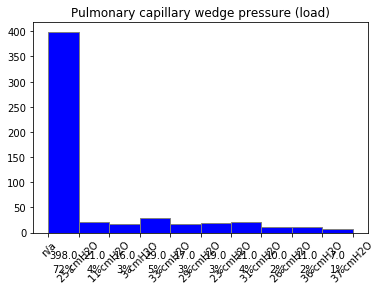

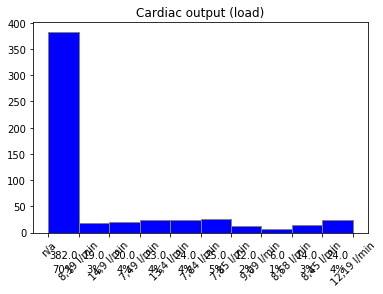

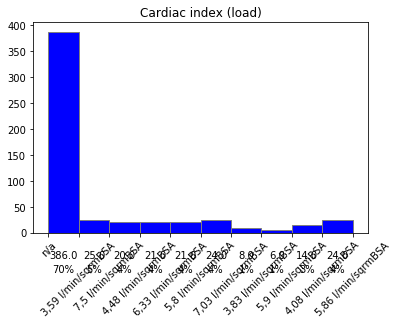

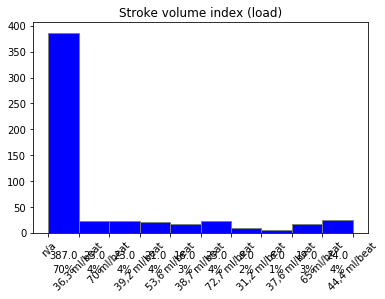

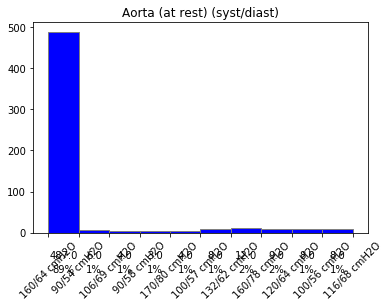

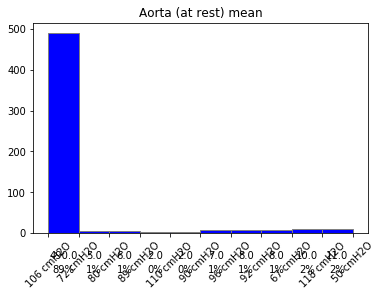

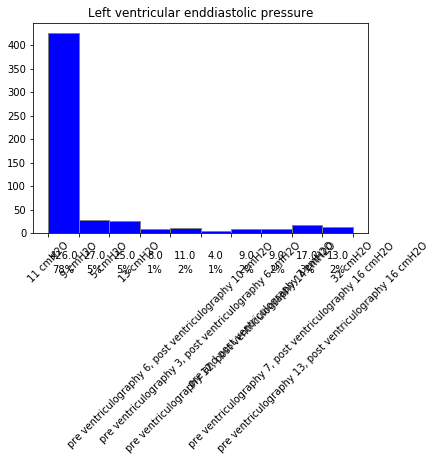

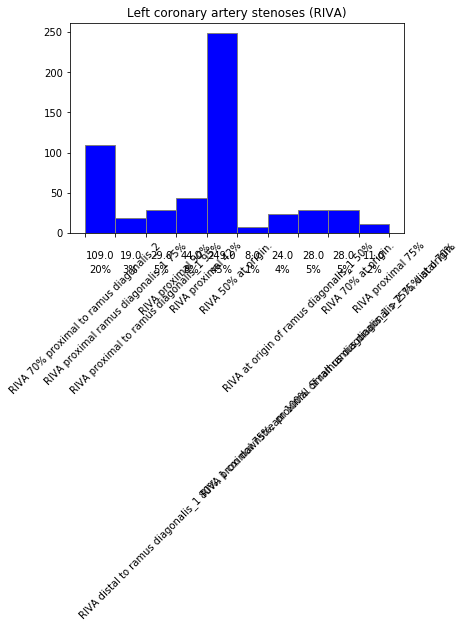

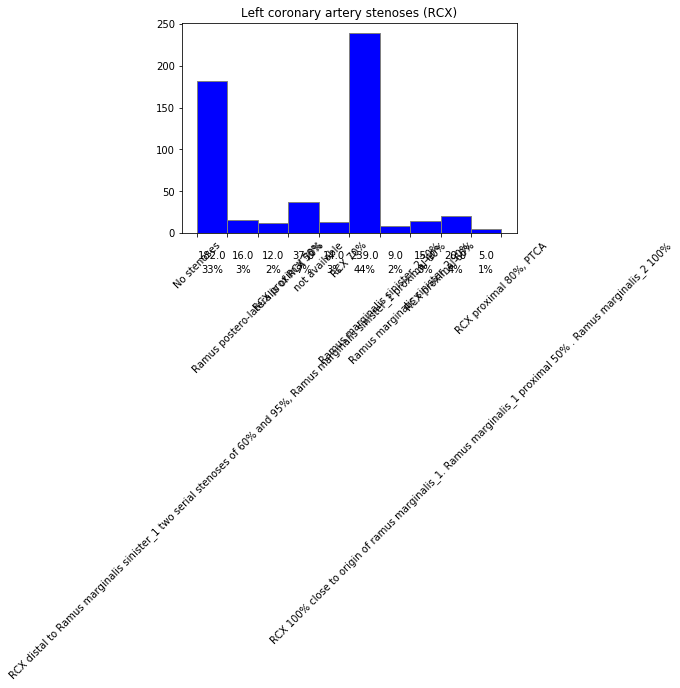

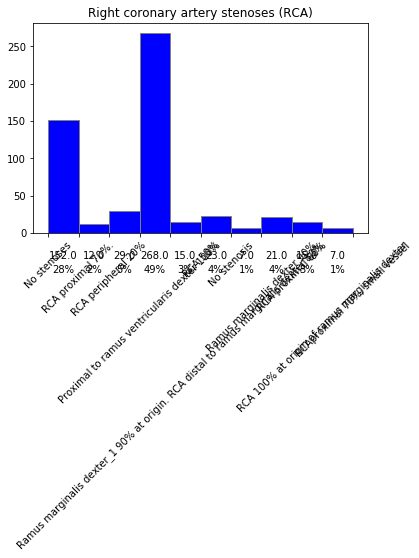

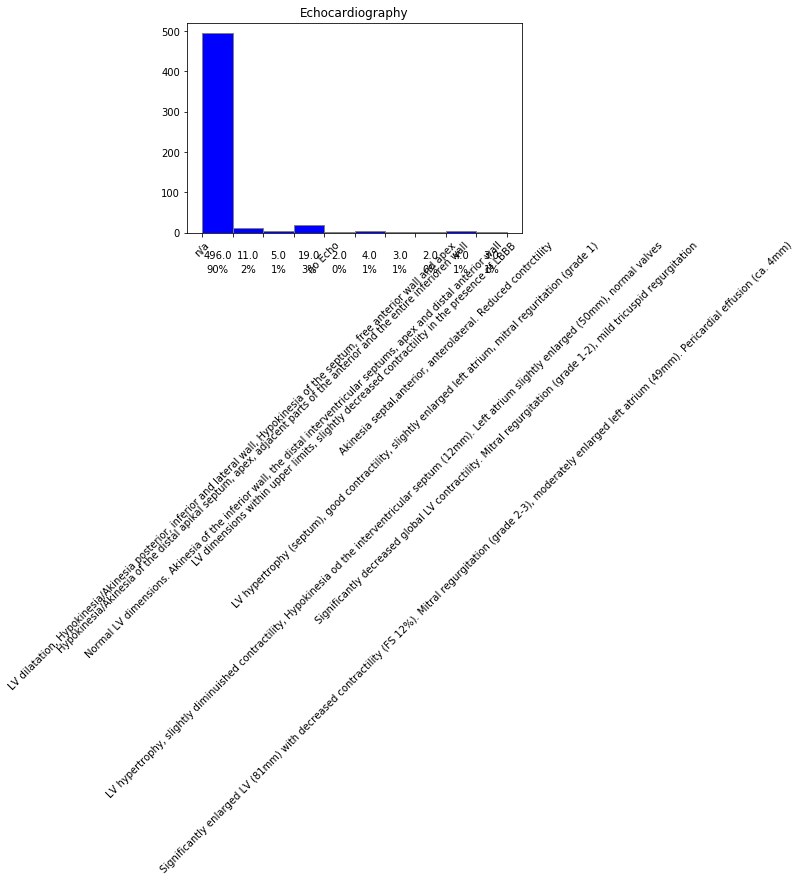

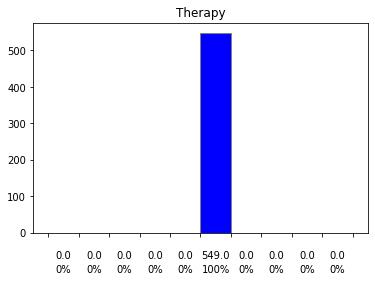

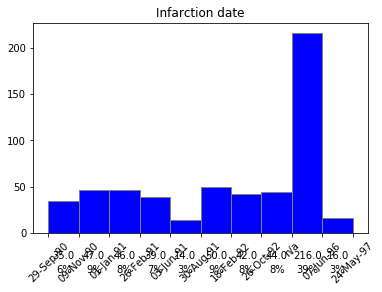

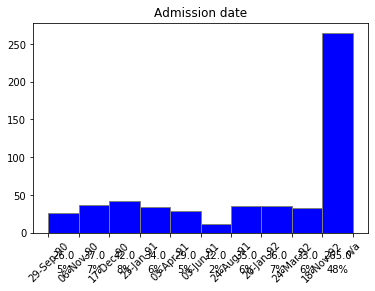

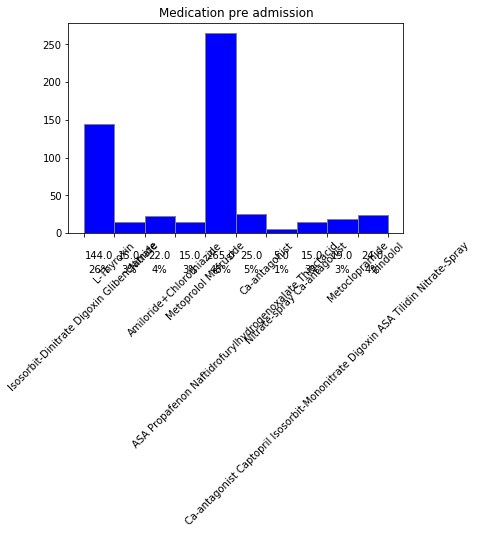

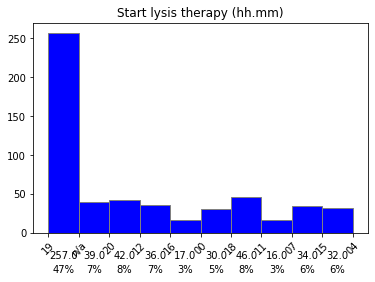

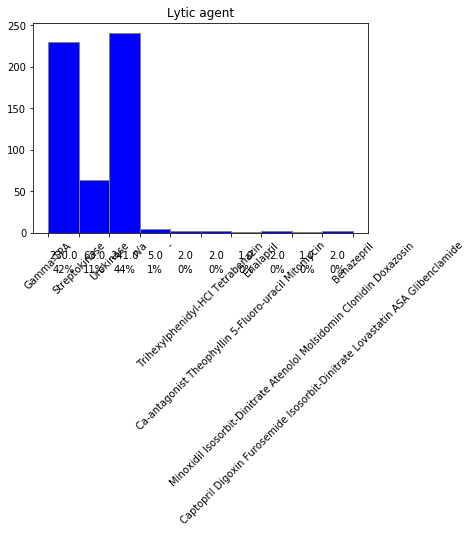

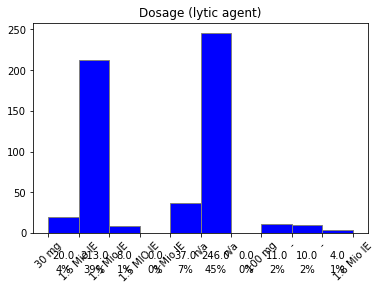

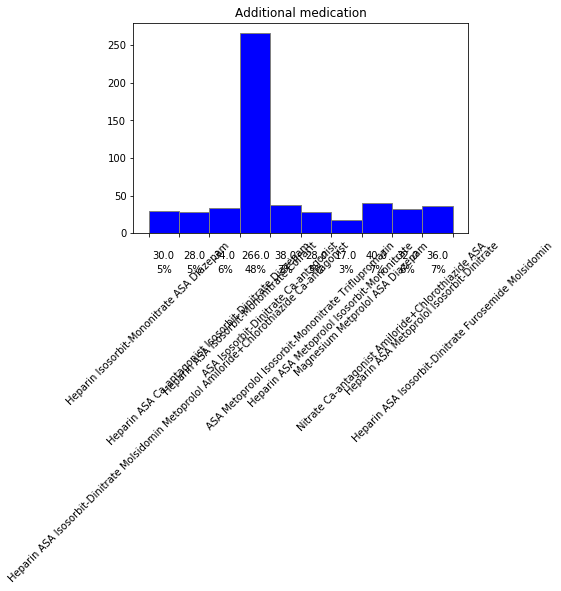

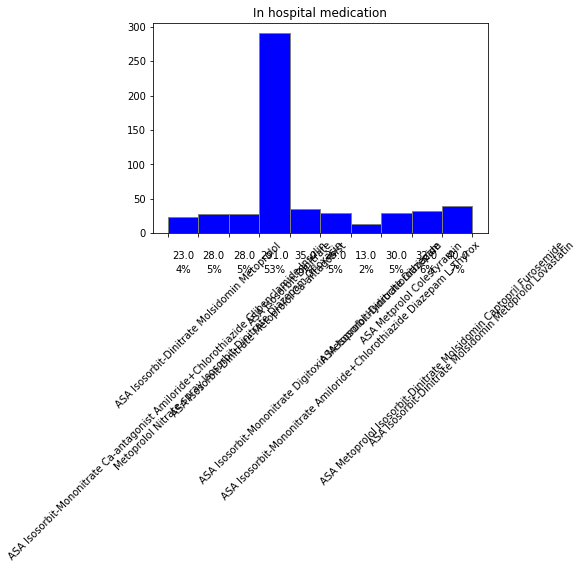

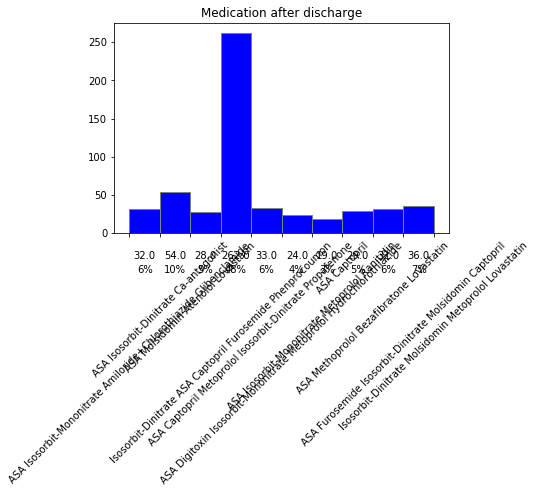

In [34]:
for k in comment_data[0].keys():
    plot([c[k] for c in comment_data], k)

In [53]:
from collections import Counter
k = "Reason for admission"
class_counts = Counter([c[k] for c in comment_data])
print(class_counts)

Counter({'Myocardial infarction': 368, 'Healthy control': 80, 'n/a': 27, 'Cardiomyopathy': 17, 'Bundle branch block': 17, 'Dysrhythmia': 16, 'Hypertrophy': 7, 'Valvular heart disease': 6, 'Myocarditis': 4, 'Stable angina': 2, 'Heart failure (NYHA 2)': 1, 'Heart failure (NYHA 3)': 1, 'Heart failure (NYHA 4)': 1, 'Palpitation': 1, 'Unstable angina': 1})


In [33]:
def plot(data, title): #https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.ticker import FormatStrFormatter
    
    fig, ax = plt.subplots()
    counts, bins, patches = ax.hist(data, facecolor='blue', edgecolor='gray')
    ax.set_title(title)
    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins)
    # Set the xaxis's tick labels to be formatted with 1 decimal place...
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    # Label the raw counts and the percentages below the x-axis...
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.15)
    plt.show()

#### Plotting (does not seem to work for annotations)

In [1]:
#wfdb.plot_wfdb(record=file_data[0], plot_sym=True, time_units='samples', title='Test', figsize=(10,4), ecg_grids='all')

#### Method for partitioning data into windows with a specific overlap
Warning: overlaps other than 0.5 have not been tested. Might also behave unexpected when 'shift' is not an Integer

In [6]:
def partition_data(data, window_size=3000, overlap=0.5, store_in_array=True, align_right=True, verbose=True): #maybe allow non float overlap too
    samples, channels = data.shape
    if samples < window_size:
        print('too few samples (%d) to support window size of %d' % (samples, window_size))
        return None    
    if verbose: print('Input data has shape:', data.shape)
    shift = window_size*overlap
    offset = int(samples % shift)
    if align_right:
        used_data = data[offset:]
    else:
        used_data = data[:-offset]
    samples, _ = used_data.shape
    if verbose: print('The window of size %d will be shifted by %f. The total data used is %d' % (window_size, shift, samples))
    partitioned = np.empty((int(samples/shift)-1, window_size, channels))
    if verbose: print('The partitioned data now has shape:', partitioned.shape)
    for i in range(len(partitioned)):
        index = int(i*shift)
        partitioned[i, :, :] = used_data[index:index+window_size, :]
    return partitioned

In [7]:
partition_data(d) #nur zum testen

Input data has shape: (120012, 15)
The window of size 3000 will be shifted by 1500.000000. The total data used is 120000
The partitioned data now has shape: (79, 3000, 15)


array([[[ 1.829 , -4.777 , -6.606 , ...,  0.966 , -4.7175,  0.523 ],
        [ 1.8185, -4.775 , -6.5935, ...,  0.964 , -4.7175,  0.522 ],
        [ 1.827 , -4.771 , -6.5985, ...,  0.9645, -4.7135,  0.5235],
        ...,
        [ 1.8325, -4.4575, -6.29  , ...,  0.983 , -4.3815,  0.4275],
        [ 1.8255, -4.4585, -6.2835, ...,  0.979 , -4.378 ,  0.427 ],
        [ 1.8185, -4.4555, -6.2745, ...,  0.9745, -4.3715,  0.427 ]],

       [[ 1.7225, -4.7125, -6.4355, ...,  0.9045, -4.5985,  0.492 ],
        [ 1.7245, -4.7125, -6.437 , ...,  0.901 , -4.595 ,  0.4935],
        [ 1.7345, -4.703 , -6.4375, ...,  0.899 , -4.601 ,  0.493 ],
        ...,
        [ 1.587 , -4.1585, -5.7455, ...,  0.805 , -4.0525,  0.3565],
        [ 1.588 , -4.158 , -5.746 , ...,  0.804 , -4.053 ,  0.354 ],
        [ 1.5785, -4.1605, -5.7395, ...,  0.8005, -4.055 ,  0.3505]],

       [[ 1.8135, -4.4485, -6.262 , ...,  0.969 , -4.3655,  0.4295],
        [ 1.8115, -4.445 , -6.2565, ...,  0.9645, -4.3645,  0.4325],
    

In [8]:
#testing 
print(partition_data(np.repeat(np.arange(10)[np.newaxis, :].T, 5, axis=1), window_size=4))
print(partition_data(np.repeat(np.arange(11)[np.newaxis, :].T, 5, axis=1), window_size=4))
print(partition_data(np.repeat(np.arange(9)[np.newaxis, :].T, 5, axis=1), window_size=4))
print(partition_data(np.repeat(np.arange(10)[np.newaxis, :].T, 5, axis=1), window_size=10))

Input data has shape: (10, 5)
The window of size 4 will be shifted by 2.000000. The total data used is 10
The partitioned data now has shape: (4, 4, 5)
[[[0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3.]]

 [[2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5.]]

 [[4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5.]
  [6. 6. 6. 6. 6.]
  [7. 7. 7. 7. 7.]]

 [[6. 6. 6. 6. 6.]
  [7. 7. 7. 7. 7.]
  [8. 8. 8. 8. 8.]
  [9. 9. 9. 9. 9.]]]
Input data has shape: (11, 5)
The window of size 4 will be shifted by 2.000000. The total data used is 10
The partitioned data now has shape: (4, 4, 5)
[[[ 1.  1.  1.  1.  1.]
  [ 2.  2.  2.  2.  2.]
  [ 3.  3.  3.  3.  3.]
  [ 4.  4.  4.  4.  4.]]

 [[ 3.  3.  3.  3.  3.]
  [ 4.  4.  4.  4.  4.]
  [ 5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.]]

 [[ 5.  5.  5.  5.  5.]
  [ 6.  6.  6.  6.  6.]
  [ 7.  7.  7.  7.  7.]
  [ 8.  8.  8.  8.  8.]]

 [[ 7.  7.  7.  7.  7.]
  [ 8.  8.  8.  8.  8.]
  [ 9.  9.  9.  9.  9.]
  [10. 10. 10. 10.

#### Generate a (hopefully correct) context task for any given partitioned data
*N* : The number of samples generated for each current window. If this number is too high (No more windows to randomly sample from) numpy will throw an error.

*observations* : The number of windows you have to predict the future.

*predictions*: The number of windows that will be predicted.

Total amount of data output will be (*Number of windows* - *observations* - *predictions*) * *N*

In [7]:
def generate_context_task(partitioned_data, N, observations=5, predictions=3, verbose=True, shuffle_all=False): #maybe use shuffle?
    #generate N-1 negative samples and 1 positive sample:
    windows, samples, channels = partitioned_data.shape
    positive_samples_x = []
    positive_samples_y = []
    negative_samples_x = []
    negative_samples_y = []
    for i in range(0, windows - observations - predictions):
        i_cur = i+observations
        positive_samples_x += [partitioned_data[i:i_cur, :, :]]
        positive_samples_y += [partitioned_data[i_cur:i_cur+predictions]]
        possible_choices = list(range(i))+list(range(i_cur+predictions, windows))get_file_list(BASE_DIR)
        for _ in range(N-1):
            choices = np.random.choice(possible_choices, predictions, replace=False) #advanced use p param for different probabilities
            negative_samples_x += [partitioned_data[i:i_cur, :, :]]
            negative_samples_y += [partitioned_data[choices, :, :]]           
    
    return positive_samples_x, positive_samples_y, negative_samples_x, negative_samples_y

In [10]:
#Testing
px, py, nx, ny = generate_context_task(partition_data(d), 10)

Input data has shape: (120012, 15)
The window of size 3000 will be shifted by 1500.000000. The total data used is 120000
The partitioned data now has shape: (79, 3000, 15)


In [121]:
(len(px), len(py)), (len(nx), len(ny))

((71, 71), (639, 639))

In [12]:
px[0].shape, py[0].shape

((5, 3000, 15), (3, 3000, 15))

In [18]:
def convert_dat_to_h5(storage_path, dat_file_paths, window_size=3000, overlap=0.5, align_right=True, verbose=True):
    if not os.path.exists(storage_path):
        os.makedirs(storage_path)
    for f in dat_file_paths:
        data = read_signal(os.path.join(BASE_DIR, f))
        print(f)
        partitioned = partition_data(data, window_size, overlap, True, align_right, verbose)
        target = os.path.join(storage_path, f.replace('/', '-') +'.h5')
        with h5py.File(target, 'w') as wf:
            wf['windows'] = partitioned
            wf.flush()
            if verbose: print(target, 'file created and written. %d windows saved.' % (len(partitioned)))

In [ ]:
record_files = get_file_list(BASE_DIR)
convert_dat_to_h5('test', record_files)

In [17]:
BASE_DIR = '/media/julian/Volume/data/ECG/ptb-diagnostic-ecg-database-1.0.0/'
record_files = get_file_list(BASE_DIR, relative=False)

file_data = []
success = 0
for f in record_files:
    header_record = read_header(f)
    print(header_record.comments)
    break

['age: 81', 'sex: female', 'ECG date: 01/10/1990', 'Diagnose:', 'Reason for admission: Myocardial infarction', 'Acute infarction (localization): infero-latera', 'Former infarction (localization): no', 'Additional diagnoses: Diabetes mellitus', 'Smoker: no', 'Number of coronary vessels involved: 1', 'Infarction date (acute): 29-Sep-90', 'Previous infarction (1) date: n/a', 'Previous infarction (2) date: n/a', 'Hemodynamics:', 'Catheterization date: 16-Oct-90', 'Ventriculography: Akinesia inferior wall', 'Chest X-ray: Heart size upper limit of norm', 'Peripheral blood Pressure (syst/diast):  140/80 mmHg', 'Pulmonary artery pressure (at rest) (syst/diast): n/a', 'Pulmonary artery pressure (at rest) (mean): n/a', 'Pulmonary capillary wedge pressure (at rest): n/a', 'Cardiac output (at rest): n/a', 'Cardiac index (at rest): n/a', 'Stroke volume index (at rest): n/a', 'Pulmonary artery pressure (laod) (syst/diast): n/a', 'Pulmonary artery pressure (laod) (mean): n/a', 'Pulmonary capillary we

In [44]:
import datetime
import time
str(datetime.datetime.now().strftime("%d_%m_%y-%H"))

'19_11_20-15'

In [81]:
def parse_comment_dict(wfdb_comment):
    comment_map = {}
    for c in wfdb_comment:
        e = c.lower().split(':')
        comment_map[e[0]] = e[1].strip()
    return comment_map
label_mappings = {}
def onehot_comment(wfdb_comment, terms: list, key_function_dict:dict = None):
    onehots = []
    if len(terms) > 0:
        terms_encoded = np.zeros(len(terms), dtype=bool)
        for i, term in enumerate(terms):
            for c in wfdb_comment:
                if term in c:
                    terms_encoded[i] = True
        onehots.append(terms_encoded)
    comment_dict = parse_comment_dict(wfdb_comment)
    for key, (func, n) in key_function_dict.items():
        if not key in label_mappings:
            label_mappings[key] = {}
        value = func(comment_dict[key])
        if not value in label_mappings[key]:
            label_mappings[key][value] = len(label_mappings[key])
        encoded_key = np.zeros(n, dtype=bool)
        encoded_key[label_mappings[key][value]] = value
        onehots.append(encoded_key)
    return np.concatenate(onehots)

def filter_comment(key, comment_string):
    c = comment_string
    if key == 'reason for admission':
        if 'cardiomyopathy' in c or 'heart failure' in c:
            return 'cardiomyopathy'
        elif 'n/a' in c or 'palpitation' in c:
            return 'miscellaneous'
        elif 'angina' in c:
            return 'angina'
    return comment_string

In [82]:
from collections import defaultdict
default_key_function_dict = defaultdict(lambda y: (lambda x: True, 2))
default_key_function_dict['age'] = lambda x: int(x)>50 if x.isnumeric() else False, 2 #age
default_key_function_dict['smoker'] = lambda x: x == 'yes', 2
default_key_function_dict['reason for admission'] = lambda x: filter_comment('reason for admission', x), 10

In [ ]:
BASE_DIR = '/media/julian/Volume/data/ECG/ptb-diagnostic-ecg-database-1.0.0/'
record_files = get_file_list(BASE_DIR, relative=False)

for f in record_files:
    wfdb_comment = read_header(f)
    print(onehot_comment(wfdb_comment, [], default_key_function_dict))    

In [85]:
label_mappings


{'age': {True: 0, False: 1},
 'smoker': {False: 0, True: 1},
 'reason for admission': {'myocardial infarction': 0,
  'healthy control': 1,
  'valvular heart disease': 2,
  'dysrhythmia': 3,
  'cardiomyopathy': 4,
  'miscellaneous': 5,
  'angina': 6,
  'hypertrophy': 7,
  'bundle branch block': 8,
  'myocarditis': 9}}

In [20]:
import numpy as np
def generate_sin_data(n, hz_low, hz_high):
    m_phase=0

    signal = np.empty(n)

    f = hz_low
    fs= 44100

    phaseInc = 2*np.pi*f/fs


    for i in range(int(n/2)):
       signal[i] = np.sin(m_phase)
       m_phase = m_phase + phaseInc

    m_phase = m_phase % 2*np.pi


    f=hz_high
    phaseInc = 2*np.pi*f/fs


    for i in range(int(n/2), n):
       signal[i] = np.sin(m_phase)
       m_phase = m_phase + phaseInc
    
    m_phase = m_phase % 2*np.pi
    return signal

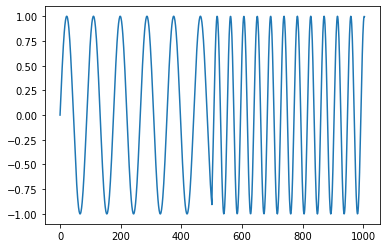

In [23]:
import matplotlib.pyplot as plt

plt.plot(generate_sin_data(1005, 500, 1000))
plt.show()

In [19]:
record_files = get_file_list(BASE_DIR, filter_function=lambda x: 'records500' in x)
print(len(record_files), 'files found')

21837 files found


In [6]:
import torch as t

In [25]:
tar = t.zeros((4,8))
tar[0,1] = 1.
tar
y = tar

In [26]:
pred = torch.rand_like(tar)
pred[:, 1:5] = 0.
pred
logits = pred

In [24]:
t.sum((pred != 0.0) | (tar != 0.0))

tensor(17)

In [37]:
t.sum(t.abs(y-pred) <= 0.000005)/(4*8)

tensor(0.4688)

In [4]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/media/julian/Volume/data/ECG/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
#X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
#X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
#X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [5]:
y_train

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19634, dtype: object

In [ ]:
dfgdfg